In [57]:
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('AirPassengers.csv')
print(data.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


In [58]:
#dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m')

data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


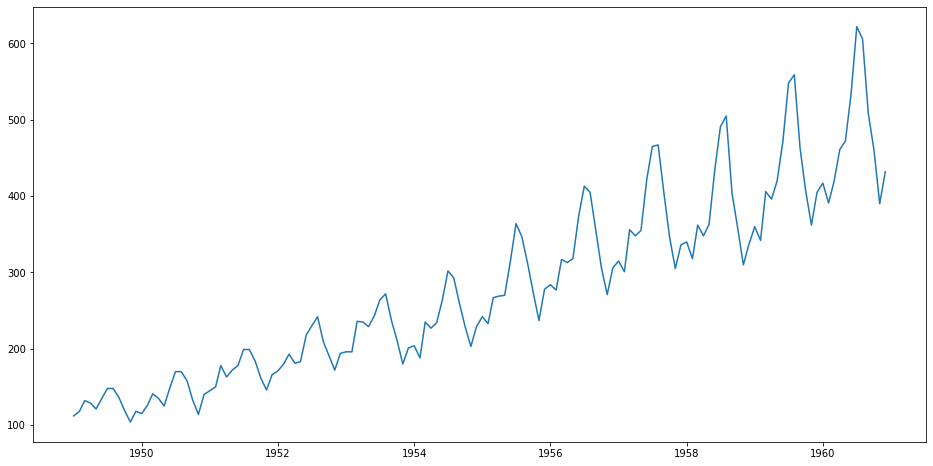

In [36]:
plt.figure(figsize=(16,8))
plt.plot(data)
df = data

# AD Fuller Test

In [37]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(12,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

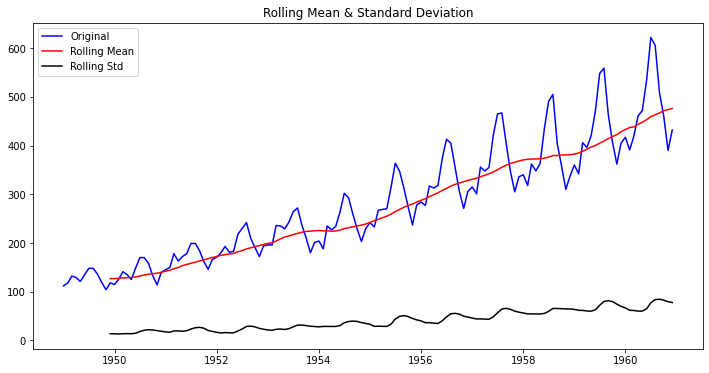

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [38]:
test_stationarity(data.iloc[:,0])

# Exponential Smoothening

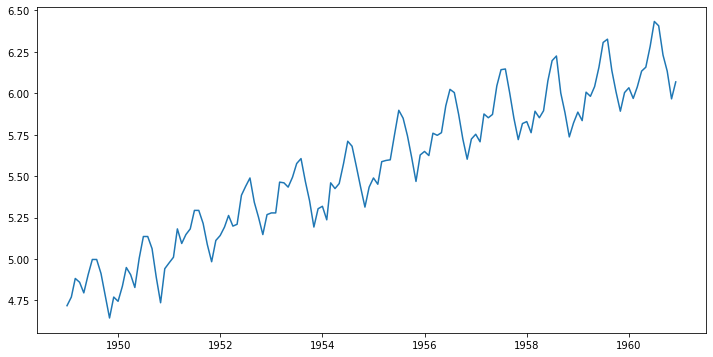

In [39]:
import numpy as np
ts_log = np.log(data)
plt.figure(figsize=(12,6))
plt.plot(ts_log)

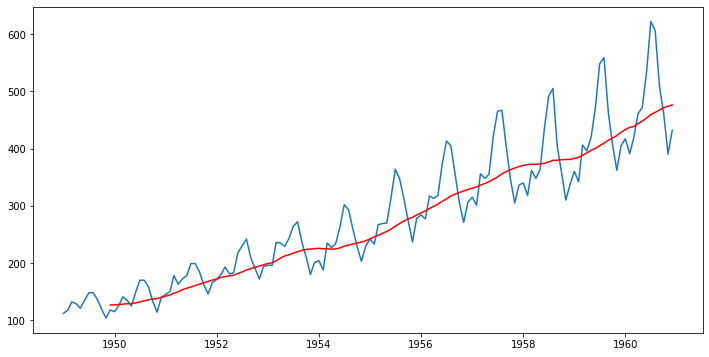

In [40]:
moving_avg = data.rolling(12).mean()
plt.figure(figsize=(12,6))
plt.plot(data)
plt.plot(moving_avg, color='red')

In [41]:
## Subtracting the The Data with Moving average to Re-Check Statianarity 

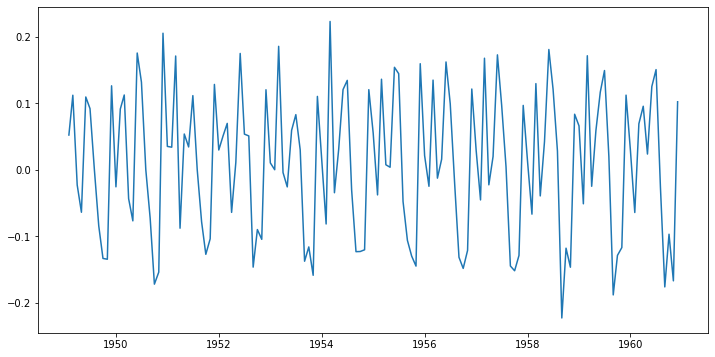

In [42]:
ts_log_diff = ts_log - ts_log.shift() # Shift index by desired number of periods with an optional time freq. This function takes a scalar parameter called the period, which represents the number of shifts to be made over the desired axis. This function is very helpful when dealing with time-series data.
plt.figure(figsize=(12,6))
plt.plot(ts_log_diff)

## Now finally we cans see the Statianarity of the Data and We can confirm it by Redoing the ADFuller Test 

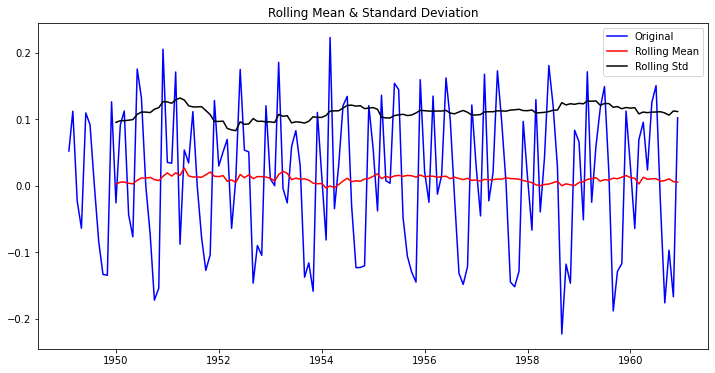

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [43]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff.iloc[:,0])

# Seasonal Decompose

<Figure size 1152x576 with 0 Axes>

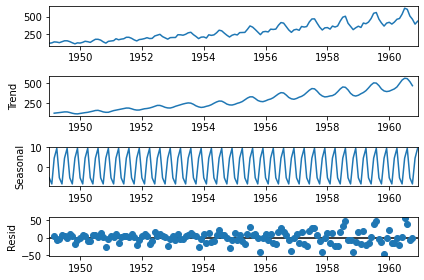

In [44]:
plt.figure(figsize=(16,8))
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(data,model='additive',period=4).plot();

# Auto Correlation and Partial AutoCorrelation Function

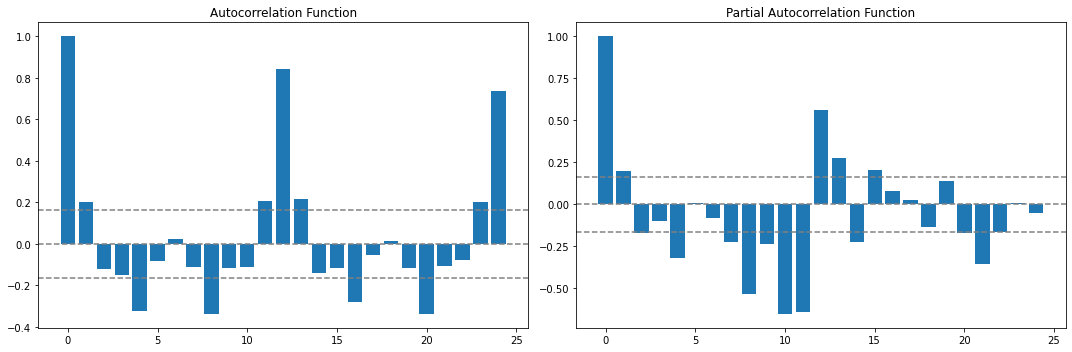

In [45]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=24)
lag_pacf = pacf(ts_log_diff, nlags=24)
plt.figure(figsize=(15,5))
lags = np.array([i for i in range(25)])
#Plot ACF: 
plt.subplot(121) 
plt.bar(lags, lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.bar(lags, lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# ARIMA

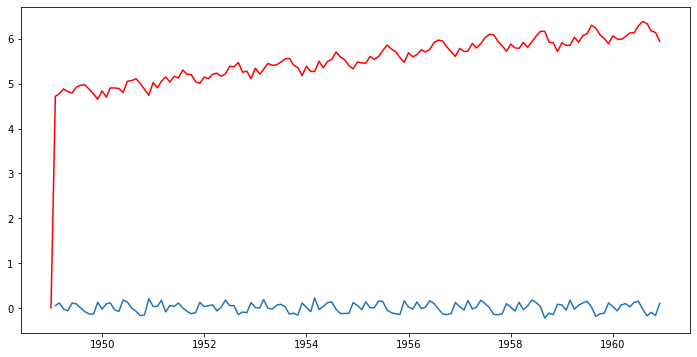

In [46]:
import statsmodels.api as sm


model = sm.tsa.arima.ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit()  
plt.figure(figsize=(12,6))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

## Adding the Predicted Values into a Series

In [47]:
import statsmodels.api as sm 
model=sm.tsa.arima.ARIMA(data,order=(1,1,1))
results=model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Mon, 21 Mar 2022   AIC                           1394.683
Time:                        14:41:47   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.000     751.362    1172.492
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 2.14
Prob(Q):                              0.65   Prob(JB):                         0.34
Heteroskedasticity (H):               7.00   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Month'>

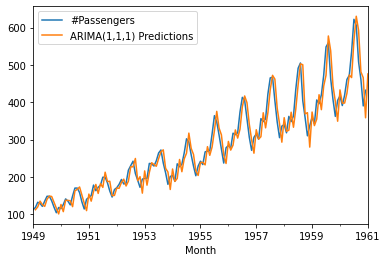

In [48]:
predictions=results.predict(1,144,typ='levels').rename('ARIMA(1,1,1) Predictions')
data.plot(legend=True)
predictions.plot(legend=True)

In [49]:
from statsmodels.tools.eval_measures import rmse
error=rmse(data,predictions)
print(np.mean(error))

163.92338004803526


<AxesSubplot:xlabel='Month'>

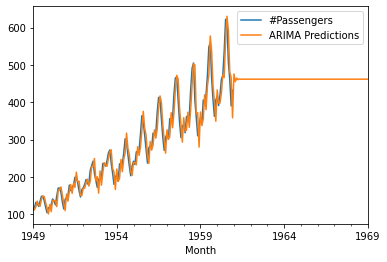

In [50]:
predictionss=results.predict(1,240,typ='levels').rename('ARIMA Predictions')
data.plot(legend=True)
predictionss.plot(legend=True)

<AxesSubplot:xlabel='Month'>

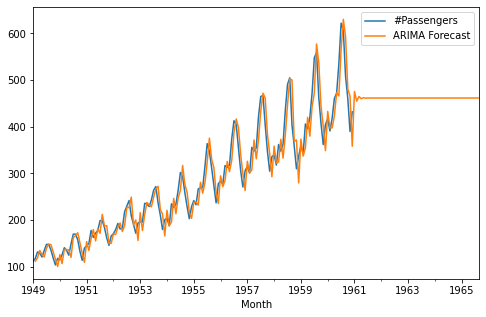

In [51]:
fcast=results.predict(1,200,typ='levels').rename('ARIMA Forecast')
data.plot(legend=True,figsize=(8,5))
fcast.plot(legend=True)

# SARIMA

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [53]:
model=SARIMAX(data,order=(1,1,1),seasonal_order=(1,0,0,12))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         #Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -566.471
Date:                             Mon, 21 Mar 2022   AIC                           1140.942
Time:                                     14:41:48   BIC                           1152.793
Sample:                                 01-01-1949   HQIC                          1145.758
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7378      0.086      8.576      0.000       0.569       0.906
ma.L1         -0.9489      0.039    -24.190      0.000      -1.026      -0.872
ar.S.L12       0.9508      0.023     41.799      0.000       0.906       0.995
sigma2       133.3462     14.182      9.402      0.000     105.550     161.143
===================================================================================
Ljung-Box (L1) (Q):                   2.28   Jarque-Bera (JB):                20.41
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               3.51   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Month'>

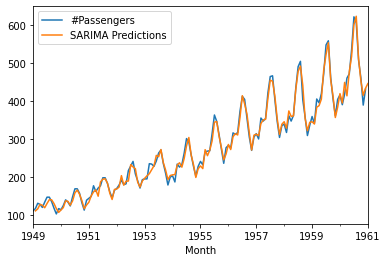

In [54]:
predictions1=results.predict(1,144,typ='levels').rename('SARIMA Predictions')
predictions=results.predict(1,144,typ='levels').rename('ARIMA(1,1,1) Predictions')
data.plot(legend=True)
predictions1.plot(legend=True)

In [55]:
from statsmodels.tools.eval_measures import rmse
error=rmse(data,predictions1)
print(np.mean(error))

163.20084927321037


<AxesSubplot:xlabel='Month'>

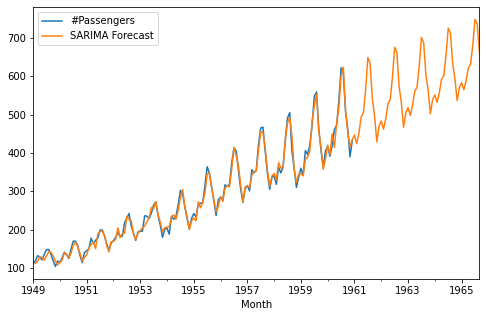

In [56]:
fcast=results.predict(1,200,typ='levels').rename('SARIMA Forecast')
data.plot(legend=True,figsize=(8,5))
fcast.plot(legend=True)